# Energy Storage Analysis


In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
import scipy

import io
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt


## Backfilling 

In [20]:
df = pd.read_csv("time_series.csv")
df.index = pd.to_datetime(df.utc_dt_naive)
df.utc_dt_naive = pd.to_datetime(df.utc_dt_naive)

number_of_gaps = len(df[df.utc_dt_naive.diff() >= timedelta(seconds=60)])
print(
    f"There are {number_of_gaps} time gaps greater than 60 seconds in the dataset based on the utc_dt_naive timestamps:"
)
s = pd.Series(df.utc_dt_naive.diff())
print("")
print(f"Gap 1: {s[s>=timedelta(seconds=60)][0]}")
print(f"Gap 2: {s[s>=timedelta(seconds=60)][1]}")


# Fill timestamps with freq's of every 1s so that no timestamps are missed
dates = pd.date_range(start=df.utc_dt_naive.min(), end=df.utc_dt_naive.max(), freq="1s")
df_reindexed = df.reindex(dates)


There are 2 time gaps greater than 60 seconds in the dataset based on the utc_dt_naive timestamps:

Gap 1: 0 days 00:03:02
Gap 2: 0 days 00:09:07


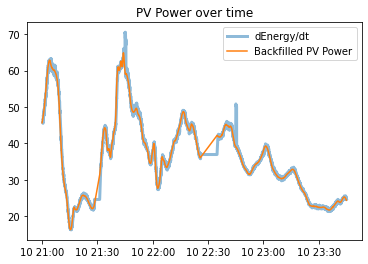

In [21]:
df_backfill = df_reindexed.interpolate(method="time", inplace=False)


df_backfill["d_pv_energy_dt"] = df_backfill.pv_pos_ltea_kwh.diff() * 3600
df_backfill["d_pv_energy_dt_ma"] = df_backfill.d_pv_energy_dt.rolling(window=30).mean()


plt.plot(df_backfill.d_pv_energy_dt_ma, label="dEnergy/dt", alpha=0.5, linewidth=3)
plt.plot(df_backfill.pv_p_kw, label="Backfilled PV Power")
plt.title("PV Power over time")
plt.legend(loc="upper right")
plt.show()


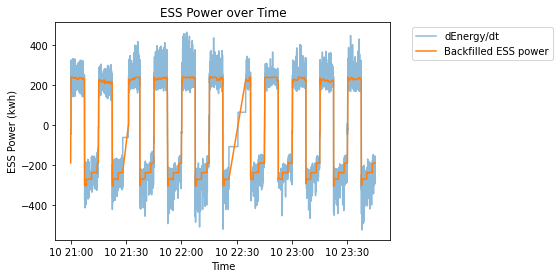

In [22]:
df_backfill = df_reindexed.interpolate(method="time", inplace=False)
df_backfill["d_ba_energy_dt"] = np.where(
    df_backfill["ba_p_kw"] < 0,
    df_backfill["ba_neg_ltea_kwh"].diff() * -3600,
    df_backfill["ba_pos_ltea_kwh"].diff() * 3600,
)


plt.plot(df_backfill.d_ba_energy_dt, label="dEnergy/dt", alpha=0.5)
plt.plot(df_backfill.ba_p_kw, label="Backfilled ESS power")
plt.xlabel("Time")
plt.ylabel("ESS Power (kwh)")
plt.title("ESS Power over Time")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.show()


 The mean 15-min net load data during the period provided is 222.139 kw
 


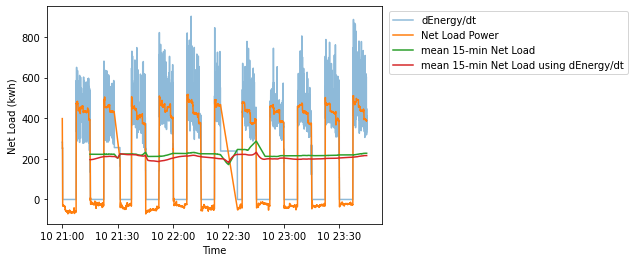

In [23]:
df_backfill = df_reindexed.iloc[:, 1:].apply(
    lambda x: x.interpolate(method="time", inplace=False)
)


df_backfill["d_ut_energy_dt"] = (df_backfill.ut_pos_ltea_kwh.diff()) * 3600
df_backfill["d_ut_energy_dt_ma_15"] = df_backfill.d_ut_energy_dt.rolling(
    window=15 * 60
).mean()
df_backfill["ut_p_kw_ma_15"] = df_backfill.ut_p_kw.rolling(window=15 * 60).mean()

print(
    f" The mean 15-min net load data during the period provided is {np.round(df_backfill['d_ut_energy_dt_ma_15'].mean(),3)} kw"
)
print(" ")

fig1 = plt.plot(df_backfill.d_ut_energy_dt, alpha=0.5, label="dEnergy/dt")
fig2 = plt.plot(df_backfill.ut_p_kw, label="Net Load Power")
fig3 = plt.plot(df_backfill.d_ut_energy_dt_ma_15, label="mean 15-min Net Load")
fig4 = plt.plot(
    df_backfill.ut_p_kw_ma_15, label="mean 15-min Net Load using dEnergy/dt"
)
plt.xlabel("Time")
plt.ylabel("Net Load (kwh)")
plt.legend(loc="upper right", bbox_to_anchor=(1.75, 1))
plt.show()


The expected demand charge for this billing period is $11,342.48 




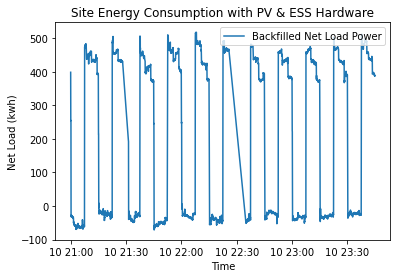

In [24]:
df_backfill = df_reindexed.interpolate(method="time", inplace=False)


df_backfill["bill_rate"] = (df_backfill.ut_p_kw / 3600) * 20

ess_pv_value = np.round(df_backfill["bill_rate"].cumsum().max(), 2)

print(
    f"""The expected demand charge for this billing period is ${ess_pv_value:,} 

"""
)


plt.plot(df_backfill.ut_p_kw, label="Backfilled Net Load Power")
plt.xlabel("Time")
plt.ylabel("Net Load (kwh)")
plt.title("Site Energy Consumption with PV & ESS Hardware")
plt.legend(
    loc="upper right",
)
plt.show()




The expected demand charge for this billing period, 
without the contributions of  PV and ESS hardware is $11,342.48 

which is $0.0 more expensive with PV and ESS hardware installed





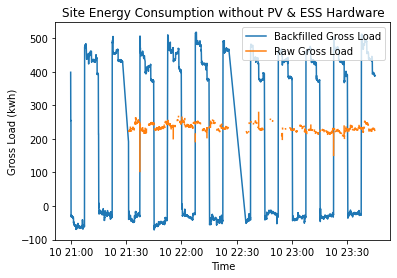

In [25]:
df_backfill = df_reindexed.interpolate(method="time", inplace=False)

df_backfill["gross_load"] = (
    (df_backfill.ut_p_kw) + (df_backfill.pv_p_kw) + (df_backfill.ba_p_kw)
)
df_backfill["bill_rate"] = (df_backfill.gross_load / 3600) * 20

df_reindexed["gross_load"] = (
    (df_reindexed.ut_p_kw) + (df_reindexed.pv_p_kw) + (df_reindexed.ba_p_kw)
)

no_ess_pv_value = np.round(df_backfill["bill_rate"].cumsum().max(), 2)
print(
    f"""

The expected demand charge for this billing period, 
without the contributions of  PV and ESS hardware is ${no_ess_pv_value:,} 

which is ${np.round(no_ess_pv_value-ess_pv_value,2):,} more expensive with PV and ESS hardware installed


"""
)


plt.plot(df_backfill.gross_load, label="Backfilled Gross Load")
plt.plot(df_reindexed.gross_load, label="Raw Gross Load")
plt.title("Site Energy Consumption without PV & ESS Hardware")
plt.xlabel("Time")
plt.ylabel("Gross Load (kwh)")
plt.legend(loc="upper right")
plt.show()
